In [1]:
import jax.numpy as np
from jax.config import config; config.update("jax_enable_x64", True)
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import astropy.io.fits as pf
import xaosim as xs
from xaosim.pupil import PHARO
# from scipy.ndimage import rotate
import xara

from tqdm import tqdm_notebook as tqdm

%matplotlib inline

import matplotlib as mpl
mpl.style.use('seaborn-colorblind')
phasemap = mpl.cm.rainbow
phasemap.set_bad(color='k')


#To make sure we have always the same matplotlib settings
#(the ones in comments are the ipython notebook settings)

mpl.rcParams['figure.figsize']=(12.0,9.0)    #(6.0,4.0)
mpl.rcParams['font.size']=20               #10 
mpl.rcParams['savefig.dpi']= 200             #72 
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
from matplotlib import rc
mpl.rcParams["font.family"] = "Times New Roman"

colours = mpl.rcParams['axes.prop_cycle'].by_key()['color']


/Users/benjaminpope/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in power
  


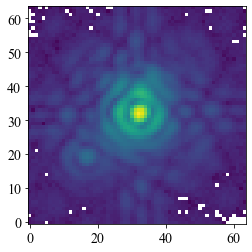

In [2]:
tgt_cube = pf.getdata('tgt_cube.fits') # alpha Ophiuchi
ca2_cube = pf.getdata('ca2_cube.fits') # epsilon Herculis

j = 0

plt.imshow(tgt_cube[j,:,:]**0.25)

/Users/benjaminpope/opt/anaconda3/lib/python3.7/site-packages/jax/lib/xla_bridge.py:122: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


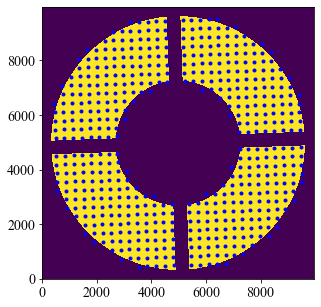

In [3]:

binary_model = False # use a finer transmission model for the aperture
PSZ     = 4978*2   # size of the array for the model
pdiam   = 4.978    # telescope diameter in meters
mstep   = 0.160    # step size in meters

pmask   = PHARO(PSZ, PSZ/2, mask="med")
pmask2  = PHARO(PSZ, PSZ/2, mask="med", ang=-2) # rotated!
ppscale = pdiam / PSZ

if binary_model:
        mtype="bina"
        p3k_model = xara.core.create_discrete_model(
                pmask, ppscale, mstep, binary=True, tmin=0.4)
else:
        mtype="grey"
        p3k_model = xara.core.create_discrete_model(
                pmask, ppscale, mstep, binary=False, tmin=0.05)
        p3k_model[:,2] = np.round(p3k_model[:,2],2)

# rotate the model by two degrees
# --------------------------------

th0 = -2.0 * np.pi / 180.0 # rotation angle
rmat = np.array([[np.cos(th0), -np.sin(th0)],
                                 [np.sin(th0), np.cos(th0)]])

p3k_model[:,:2] = p3k_model[:,:2].dot(rmat)

# -------------------------
#      simple plot
# -------------------------
f0 = plt.figure(0)
f0.clf()
ax = f0.add_subplot(111)
ax.imshow(pmask2)
ax.plot(PSZ/2+p3k_model[:,0]/ppscale,
                 PSZ/2+p3k_model[:,1]/ppscale, 'b.')
f0.set_size_inches(5,5, forward=True)

#f0.savefig("./imgs/PHARO/rotated_pupil.png")
# -------------------------


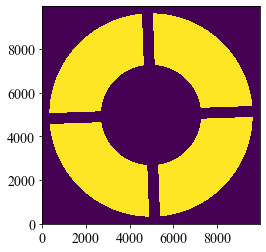

In [4]:
plt.imshow(pmask2)

Attempting to build KPI from array None
1362 distinct baselines were identified
1312 baselines were preserved after filtering
10 first singular values for this array:
[185.70474 185.69751 130.22834 130.22309  86.37561  86.3731   67.30037
  67.29565  44.92332  44.92221]

        Summary of properties for no_name
        ---------------------------------------------------------------
        - 528 sub-apertures
        - 1312 distinct baselines
        - 1048 Ker-phases (79.9 % target phase information recovery)
        - 264 Eig-phases (50.0 % wavefront information recovery)
        ---------------------------------------------------------------
        
KPI data successfully created
File provided is not a fits file
saving p3k_med_grey_model.fits
No kernel-phase data was included


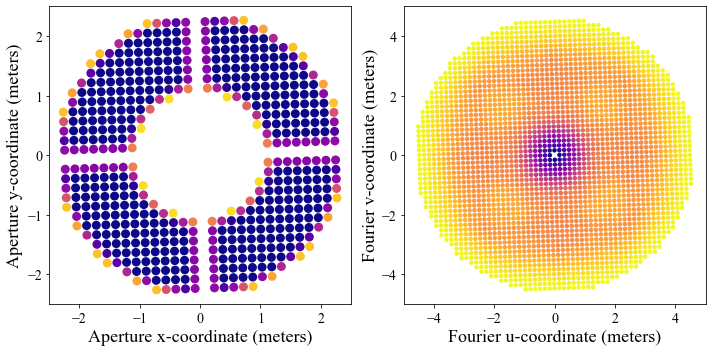

In [5]:
# compute the kernel-phase data structure
kpo_0 = xara.KPO(array=p3k_model, bmax=4.646)

# show side by side, the pupil model and its associated uv-coverage
kpo_0.kpi.plot_pupil_and_uv(xymax=2.5, cmap=cm.plasma_r, ssize=9, figsize=(10,5), marker='o')

# and save to a multi-extension kernel-phase fits file for later use
fname = "p3k_med_%s_model.fits" % (mtype,)
print("saving %s" % (fname,))
kpo_0.save_as_fits(fname)


In [6]:
# kpo1   = xara.KPO(fname="p3k_med_grey_model.fits")


/Users/benjaminpope/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in power
  


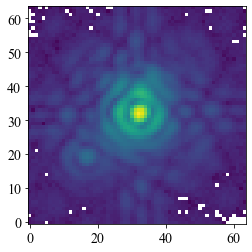

In [7]:
tgt_cube = pf.getdata('tgt_cube.fits') # alpha Ophiuchi
ca2_cube = pf.getdata('ca2_cube.fits') # epsilon Herculis

j = 0

plt.imshow(tgt_cube[j,:,:]**0.25)

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as pf
import xara

pscale = 25.0              # plate scale of the image in mas/pixels
wl     = 2.145e-6          # central wavelength in meters (Hayward paper)
ISZ    = tgt_cube.shape[1] # image size
c = xara.KPO(fname="p3k_med_grey_model.fits")
kpo1   = c.copy()
kpo2   = c.copy()

kpo1.extract_KPD_single_cube(
        tgt_cube, pscale, wl,target="alpha Ophiuchi", recenter=True)
kpo2.extract_KPD_single_cube(
        ca2_cube, pscale, wl, target="epsilon Herculis", recenter=True)


Attempting to load file p3k_med_grey_model.fits
KPI data successfully loaded
The file contains 0 data-sets
CWAVEL was not set
No covariance data available

Cube slice   1 / 100First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...
Done!
Cube slice 100 / 100
Cube slice   1 / 100First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...
Done!
Cube slice 100 / 100

/Users/benjaminpope/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in power
  """Entry point for launching an IPython kernel.


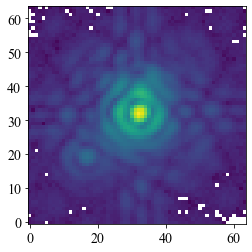

In [9]:
plt.imshow(tgt_cube[0,:,:]**0.25)

In [10]:
data1 = np.array(kpo1.KPDT)[0]
data2 = np.array(kpo2.KPDT)[0]

mydata = np.median(data1, axis=0) - np.median(data2, axis=0)
myerr  = np.sqrt(np.var(data1, axis=0) / (kpo1.KPDT[0].shape[0] - 1) + np.var(data2, axis=0) / (kpo2.KPDT[0].shape[0] - 1))
myerr = np.sqrt(myerr**2 + 1.2**2)
# myerr = (1.2**2)


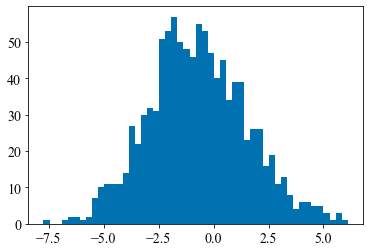

In [11]:
plt.hist(mydata,bins=50);

In [12]:
print("\ncomputing colinearity map...")
gsize = 100 # gsize x gsize grid
gstep = 10 # grid step in mas
xx, yy = np.meshgrid(
        np.arange(gsize) - gsize/2, np.arange(gsize) - gsize/2)
azim = -np.arctan2(xx, yy) * 180.0 / np.pi
dist = np.hypot(xx, yy) * gstep

#mmap = kpo1.kpd_binary_match_map(100, 10, mydata/myerr, norm=True)
mmap_raw = kpo1.kpd_binary_match_map(100, 10, np.median(data1, axis=0), norm=True)
mmap_calib = kpo1.kpd_binary_match_map(100, 10, np.median(data2, axis=0), norm=True)
mmap = kpo1.kpd_binary_match_map(100, 10, mydata, norm=True)

x0, y0 = np.argmax(mmap) % gsize, np.argmax(mmap) // gsize
print("max colinearity found for sep = %.2f mas and ang = %.2f deg" % (
        dist[y0, x0], azim[y0, x0]))



computing colinearity map...
max colinearity found for sep = 100.50 mas and ang = 84.29 deg


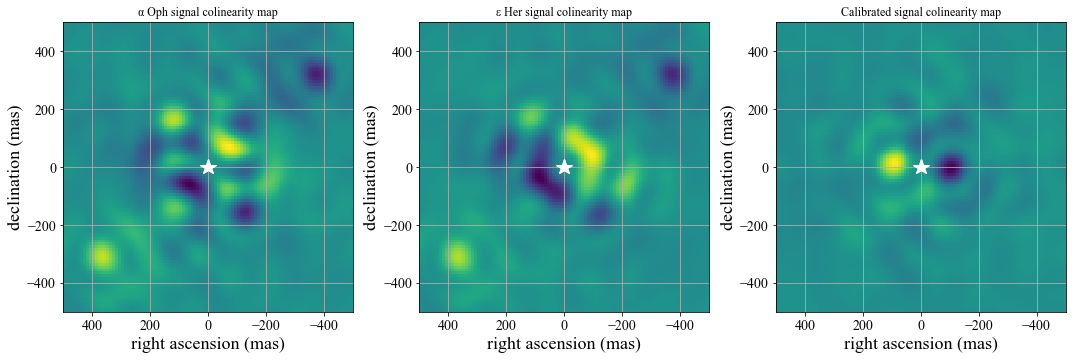

In [13]:

f1, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,5))
ax1.imshow(mmap_raw, extent=(
        gsize/2*gstep, -gsize/2*gstep, -gsize/2*gstep, gsize/2*gstep))
ax1.set_xlabel("right ascension (mas)")
ax1.set_ylabel("declination (mas)")
ax1.plot([0,0], [0,0], "w*", ms=16)
ax1.set_title("α Oph signal colinearity map")
ax1.grid()

ax2.imshow(mmap_calib, extent=(
        gsize/2*gstep, -gsize/2*gstep, -gsize/2*gstep, gsize/2*gstep))
ax2.set_xlabel("right ascension (mas)")
ax2.set_ylabel("declination (mas)")
ax2.plot([0,0], [0,0], "w*", ms=16)
ax2.set_title("ε Her signal colinearity map")
ax2.grid()

ax3.imshow(mmap, extent=(
        gsize/2*gstep, -gsize/2*gstep, -gsize/2*gstep, gsize/2*gstep))
ax3.set_xlabel("right ascension (mas)")
ax3.set_ylabel("declination (mas)")
ax3.plot([0,0], [0,0], "w*", ms=16)
ax3.set_title("Calibrated signal colinearity map")
ax3.grid()

f1.set_tight_layout(True)




computing colinearity map...
max colinearity found for sep = 100.50 mas and ang = 84.29 deg


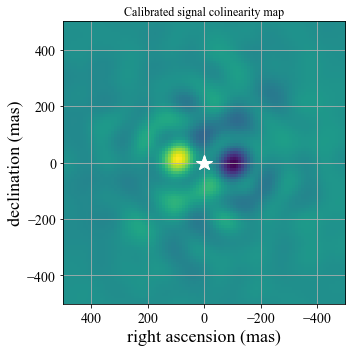

In [14]:
print("\ncomputing colinearity map...")
gsize = 100 # gsize x gsize grid
gstep = 10 # grid step in mas
xx, yy = np.meshgrid(
        np.arange(gsize) - gsize/2, np.arange(gsize) - gsize/2)
azim = -np.arctan2(xx, yy) * 180.0 / np.pi
dist = np.hypot(xx, yy) * gstep

#mmap = kpo1.kpd_binary_match_map(100, 10, mydata/myerr, norm=True)
mmap = kpo1.kpd_binary_match_map(100, 10, mydata, norm=True)
x0, y0 = np.argmax(mmap) % gsize, np.argmax(mmap) // gsize
print("max colinearity found for sep = %.2f mas and ang = %.2f deg" % (
        dist[y0, x0], azim[y0, x0]))

f1 = plt.figure(figsize=(5,5))
ax1 = f1.add_subplot(111)
ax1.imshow(mmap, extent=(
        gsize/2*gstep, -gsize/2*gstep, -gsize/2*gstep, gsize/2*gstep))
ax1.set_xlabel("right ascension (mas)")
ax1.set_ylabel("declination (mas)")
ax1.plot([0,0], [0,0], "w*", ms=16)
ax1.set_title("Calibrated signal colinearity map")
ax1.grid()
f1.set_tight_layout(True)
f1.canvas.draw()



binary model fitting...
sep = 124.557747, ang=86.550018, con=24.525299 => chi2 = 1.052
correlation matrix of parameters
[[ 2.63 -0.04 -1.17]
 [-0.04  0.21  0.01]
 [-1.17  0.01  0.94]]
Estimated Uncertainty
[1.62313315 0.46017107 0.96840095]


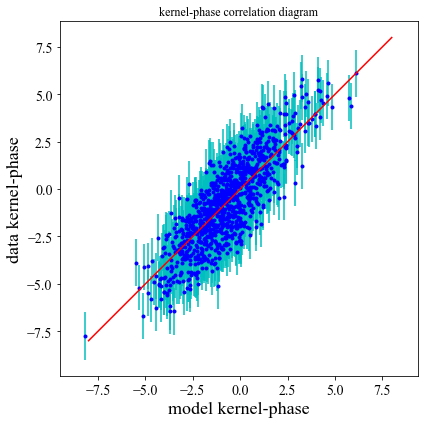

In [15]:
print("\nbinary model fitting...")
p0 = [dist[y0, x0], azim[y0, x0], mmap.max()] # good starting point

mfit = kpo1.binary_model_fit(p0, calib=kpo2)
p1 = mfit[0] # the best fit parameter vector (sep, P.A., contrast)

p2 = np.array(p1)#+np.sqrt(np.diag(mfit[1]))

cvis_b = xara.core.cvis_binary(
        kpo1.kpi.UVC[:,0], kpo1.kpi.UVC[:,1], wl, p2) # binary
ker_theo = kpo1.kpi.KPM.dot(np.angle(cvis_b))

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)

ax.errorbar(ker_theo, mydata, yerr=myerr, fmt="none", ecolor='c')
ax.plot(ker_theo, mydata, 'b.')
mmax = np.round(np.abs(mydata).max())
ax.plot([-mmax,mmax],[-mmax,mmax], 'r')
ax.set_ylabel("data kernel-phase")
ax.set_xlabel("model kernel-phase")
ax.set_title('kernel-phase correlation diagram')
ax.axis("equal")
# ax.axis([-11, 11, -11, 11])
fig.set_tight_layout(True)

if myerr is not None:
        chi2 = np.sum(((mydata - ker_theo)/myerr)**2) / kpo1.kpi.nbkp
else:
        chi2 = np.sum(((mydata - ker_theo))**2) / kpo1.kpi.nbkp

print("sep = %3f, ang=%3f, con=%3f => chi2 = %.3f" % (p1[0], p1[1], p1[2], chi2))
print("correlation matrix of parameters")
print(np.round(mfit[1], 2))
print('Estimated Uncertainty')
print(np.sqrt(np.diag(mfit[1])))

In [16]:
print(kpo1.kpi.TFM.shape)
print(kpo1.kpi.VAC.shape)
print(kpo1.kpi.UVC.shape)

(1312, 527)
(528, 3)
(1312, 2)


In [17]:
# kpo1.kpd = mydata
# kpo1.plot_uv_map()

In [18]:
kpo1.kpi.VAC.shape

(528, 3)

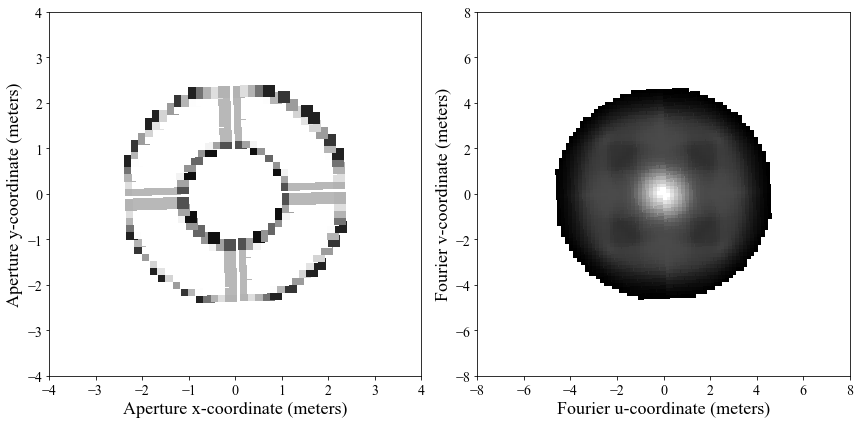

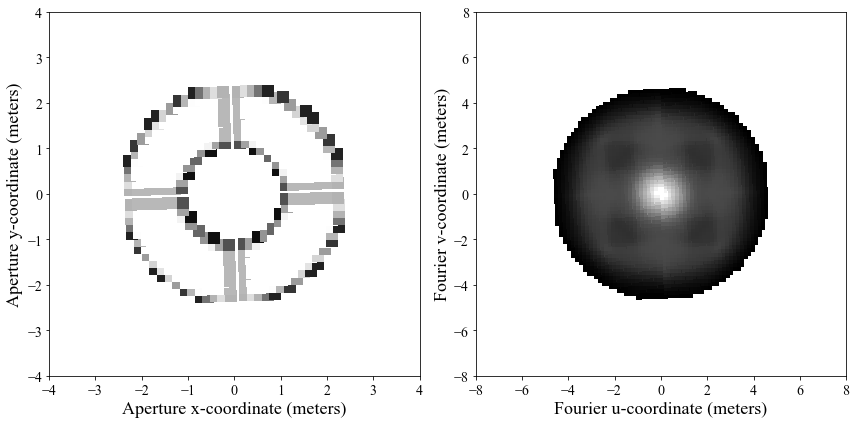

In [19]:
kpo1.kpi.plot_pupil_and_uv()

### Let's try emcee

In [20]:
import emcee

In [21]:
paramlimits=[40,250,0,360,1.1,50.]

def binary_model(params,kpo):
    u = kpo.kpi.UVC[:,0]
    v = kpo.kpi.UVC[:,1]
    wl = kpo.CWAVEL
    detpa = 0
    return(xara.core.cvis_binary(u,v,wl, params, detpa))

def kp_loglikelihood(params,kpo):
    temp = binary_model(params,kpo)
    model = kpo.kpi.KPM.dot(np.angle(temp))
    error = mydata-model
    error /= (myerr)
    chi2 = -np.sum((error)**2)
    return chi2 

def lnprior(params):
    if paramlimits[0] < params[0] < paramlimits[1] and paramlimits[2] < params[1] < paramlimits[3] and paramlimits[4] < params[2] < paramlimits[5]:
        return -np.log(params[0]) -np.log(params[2])
    return -np.inf

def lnprob(params,kpo):
    return lnprior(params) + kp_loglikelihood(params,kpo)

ndim=3
nwalkers=100
plot=False
burnin=100
nsteps=1000

import time


In [22]:
ivar = np.array(p0)  # initial parameters for model-fit

ball = np.array([ivar + 0.1*ivar*np.random.rand(ndim) for i in range(nwalkers)]) # initialise walkers in a ball

print('Running emcee now!')

t0 = time.time()

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[kpo1])

# burn in
pos,prob,state = sampler.run_mcmc(ball, burnin)
sampler.reset()

t1 = time.time()

print('Burnt in! Took %.3f seconds' %(t1-t0))


Running emcee now!
Burnt in! Took 24.557 seconds


In [23]:
# restart
sampler.run_mcmc(pos,nsteps)

tf = time.time()

print('Time elapsed = %.3f s' %(tf-t0))

seps = sampler.flatchain[:,0]
ths = sampler.flatchain[:,1]

meansep = np.mean(seps)
dsep = np.std(seps)

meanth = np.mean(ths)
dth = np.std(ths)

cs = sampler.flatchain[:,2]
bestcon = np.mean(cs)
conerr = np.std(cs)

print('Separation %.3f pm %.3f mas' % (meansep,dsep))
print('Position angle %.3f pm %.3f deg' % (meanth,dth))
print('Contrast at',wl,'um %.3f pm %.3f' % (bestcon,conerr))


Time elapsed = 251.967 s
Separation 121.887 pm 0.995 mas
Position angle 86.757 pm 0.250 deg
Contrast at 2.145e-06 um 24.708 pm 0.547


In [24]:
import corner

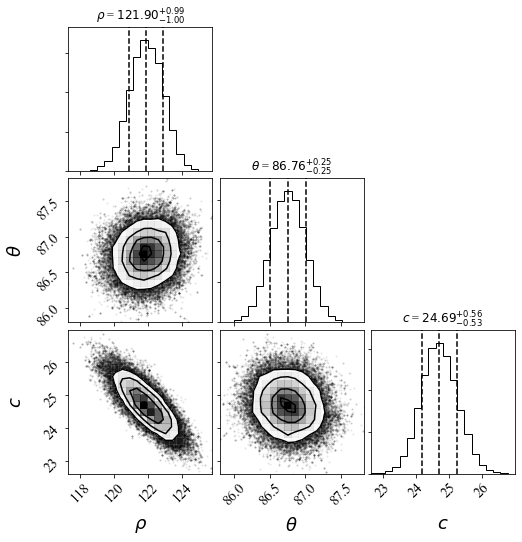

In [25]:
# Plot it.
figure = corner.corner(sampler.flatchain, labels=[r"$\rho$", r"$\theta$", r"$c$",],
                       quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, title_kwargs={"fontsize": 12})


In [26]:
autodiff = np.loadtxt('autodiff_128.txt')

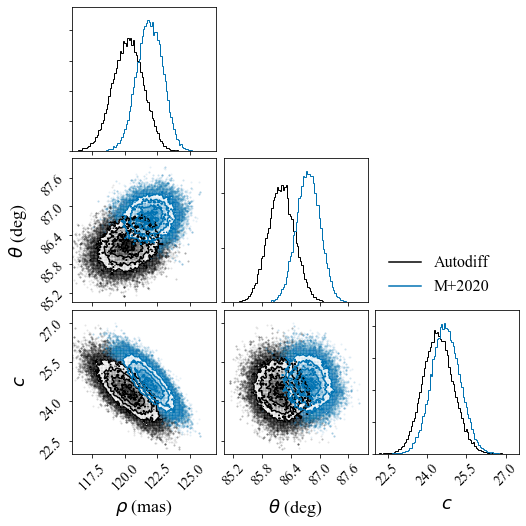

In [27]:
# Plot it.
import matplotlib.lines as mlines

# Plot it.
plotrange = ((116,127),(85,88),(22,27.5))
hist_kwargs = {}

figure = corner.corner(autodiff, range=plotrange, labels=[r"$\rho$ (mas)", r"$\theta$ (deg)", r"$c$",],
                       show_titles=False, title_kwargs={"fontsize": 12},color='k',bins=100,
                       scale_hist=True
                       )

corner.corner(sampler.flatchain, fig=figure,color=colours[0],range=plotrange,bins=100)


lines = [mlines.Line2D([], [], color='k', label='Autodiff'),mlines.Line2D([], [], color=colours[0], label='M+2020')]
plt.legend(handles=lines, bbox_to_anchor=(0., 1.0, 1., .0),fontsize=16,frameon=False);
plt.savefig('comparison_posterior.png',bbox_inches='tight')
plt.savefig('/Users/benjaminpope/code/morphine/paper/comparison_posterior.pdf',rasterized=True,bbox_inches='tight')

### Let's look at the OTF

In [28]:
baselines = np.sqrt(np.sum(kpo2.kpi.UVC**2,axis=1))
theory_otf = kpo1.kpi.RED

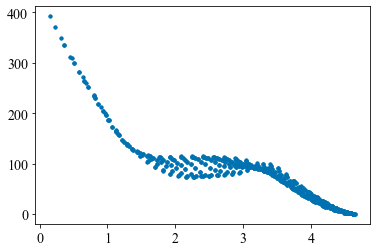

In [29]:
plt.plot(baselines,theory_otf,'.')

In [30]:
vis_frantz = np.median(kpo2.CVIS[0],axis=0)

/Users/benjaminpope/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


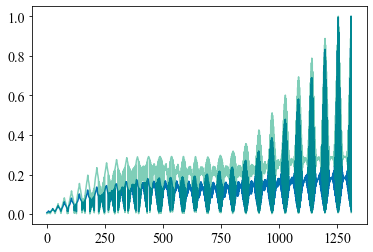

In [31]:
plt.plot(vis_frantz/vis_frantz.max())
plt.plot((theory_otf/theory_otf.max()),alpha=0.5)

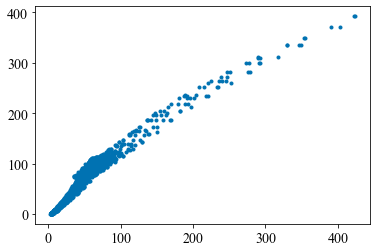

In [32]:
plt.plot(vis_frantz,theory_otf,'.')

In [33]:
pscale

25.0

## Now let's see how well it works on simulated data

In [34]:
from scipy.optimize import leastsq, minimize
import numpy as onp
from jax import grad, jacfwd, jacrev
from scipy.ndimage import fourier_shift


def shift(im,dx,dy):
    input_ = onp.fft.fft2(im)
    result = fourier_shift(input_, shift=(dx,dy))
    return onp.real(onp.fft.ifft2(result))

def sim_binary(im,sep,th,con,pscale):
    sep_pix = sep/pscale
    th_rad = np.pi*th/180.
    dx, dy = sep_pix*np.cos(-th_rad), sep_pix*np.sin(-th_rad)
    shifted = shift(im,dx,dy)
    return im+shifted/con 

def preprocess_like(data,kpo):
    isz = 64
    xsz,ysz = data.shape
    wrad = 50
    pscale = 25.0                              # plate scale (mas)
    cwavel = kpo.CWAVEL  # central wavelength
    m2pix  = xara.core.mas2rad(pscale)*isz/cwavel   # Fourier scaling
    tdiam  = 5.0                               # telescope diameter (m)
    spix   = xara.core.rad2mas(cwavel/tdiam)/pscale # image sampling (pixels)

    (x0, y0) = xara.core.determine_origin(data, mask=None,
                                     algo="BCEN", verbose=False,
                                     wmin=2.0*spix)

    x1, y1 = int(x0-isz/2), int(y0-isz/2)
    img = data[y1:y1+isz, x1:x1+isz] # image is now (isz x isz)
    dy, dx   = (y0-ysz/2), (x0-xsz/2)

    sgmask = xara.core.super_gauss(isz, isz, isz/2, isz/2, wrad)
    (x0, y0) = xara.core.determine_origin(img, mask=sgmask,
                                     algo="BCEN", verbose=False,
                                     wmin=2.0*spix)

    img = xara.core.recenter(data,verbose=False)
    nx,ny = img.shape
    limsx = int(nx/2-64), int(nx/2+64)
    limsy = int(ny/2-64), int(ny/2+64)
    img = img[limsx[0]:limsx[1],limsy[0]:limsy[1]] # from 512x512 -> 128x128
    return img

def simulate(truth,cal):
    binary = sim_binary(cal,*truth,25.0)
    calib = np.median(data2[50:,:], axis=0)
    myerr = np.std(data2[50:,:],axis=0)
    # img_sim = preprocess_like(binary,b)
    img_sim = binary
    a = c.copy()
    wl = kpo1.CWAVEL
    a.extract_KPD_single_frame(
    img_sim, 25.0, wl, recenter=True,method='LDFT1')
    mydata = a.KPDT[0][0] - calib

    def binary_model(params):
        u = a.kpi.UVC[:,0]
        v = a.kpi.UVC[:,1]
        return(xara.core.cvis_binary_jax(u,v,2.145e-06, params, 0))

    def ben_binary_model_fit_residuals(params,index=0,obs="KERNEL",err=1.0):
        temp = binary_model(params)
        model = np.array(a.kpi.KPM).dot(np.angle(temp))
        error = mydata-model
        error /= (err)
        return np.array(error)

    def ben_binary_model_fit_chi2(params):
        residuals = ben_binary_model_fit_residuals(params,kpo=a,index=0,obs="KERNEL",err=myerr)
        chi2 = np.sum(np.abs(residuals)**2)
        return chi2

    from jax import jit

    chi2_jac = jacrev(ben_binary_model_fit_chi2)
    chi2_jac_np = lambda x:onp.array(jit(chi2_jac)(x))

    def ben_binary_model_fit2(p0,index=0,obs='KERNEL',err=myerr):
        soluce = leastsq(ben_binary_model_fit_residuals, 
                     p0, args=((index, obs, err)), full_output=1)
    #     soluce = minimize(ben_binary_model_fit_chi2,p0,method='BFGS',jac=chi2_jac_np)
    #     p1 = soluce['x'][0] # the best fit parameter vector (sep, P.A., contrast)
        return soluce

    
    print("\nbinary model fitting...")
    # p0 = params0 # good starting point
    # p0 =  [dist[y0, x0], azim[y0, x0], mmap.max()] # good starting point

    p0 = truth
    p0[1] = np.mod(p0[1],360.)

    wl = a.CWAVEL

    # mfit = a.binary_model_fit(p0)
    mfit = ben_binary_model_fit2(p0,err=myerr)

    p1 = mfit[0] # the best fit parameter vector (sep, P.A., contrast)
    # p1 = mfit['x']
    p1[1] = np.mod(p1[1],360.)
    # p1 = p0
    # p1 = p0

    cvis_b = xara.core.cvis_binary(
            a.kpi.UVC[:,0], a.kpi.UVC[:,1], wl, p1) # binary
    ker_theo = a.kpi.KPM.dot(np.angle(cvis_b))
    
    def get_chi2(addederror):
        return np.sum(((mydata - np.array(ker_theo))/np.sqrt(myerr**2+addederror**2))**2) / (1.0*a.kpi.nbkp)

    def add_error():
        def get_objective(addederror):
            return np.abs(get_chi2(addederror)-1.)
        jac = grad(get_objective)
        return minimize(get_objective,0.0025,method='BFGS')['x']

    added_error = add_error()
    this_error = np.sqrt(myerr**2+added_error**2)
    print(added_error)
    mfit = ben_binary_model_fit2(p1,err=this_error)
    p2 = mfit[0]#+np.sqrt(np.diag(mfit[1]))

    cvis_b = xara.core.cvis_binary(
            a.kpi.UVC[:,0], a.kpi.UVC[:,1], wl, p2) # binary
    ker_theo = a.kpi.KPM.dot(np.angle(cvis_b))

    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)

    ax.errorbar(ker_theo, mydata, yerr=this_error, fmt="none", ecolor='c')
    ax.plot(ker_theo, mydata, 'b.')
    mmax = (np.abs(mydata).max())
    ax.plot([-mmax,mmax],[-mmax,mmax], 'r')
    ax.set_ylabel("data kernel-phase")
    ax.set_xlabel("model kernel-phase")
    ax.set_title('kernel-phase correlation diagram')
    ax.axis("equal")
    # ax.axis([-11, 11, -11, 11])
    fig.set_tight_layout(True)

    if myerr is not None:
            chi2 = np.sum(((mydata - ker_theo)/(this_error))**2) / a.kpi.nbkp
    else:
            chi2 = np.sum(((mydata - ker_theo))**2) / a.kpi.nbkp

    print("sep = %3f, ang=%3f, con=%3f => chi2 = %.3f" % (p1[0], p1[1], p1[2], chi2))
    print("correlation matrix of parameters")
    # hess_inv = mfit['hess_inv']
    hess_inv = mfit[1]
    print(np.round(hess_inv, 2))
    print('Estimated Uncertainty')
    print(np.sqrt(np.diag(hess_inv)))
    return p2, np.sqrt(np.diag(hess_inv))

First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...
Done!

binary model fitting...
[4.0694423e-10]
sep = 299.894718, ang=89.843000, con=25.646661 => chi2 = 0.880
correlation matrix of parameters
[[0.81 0.01 0.03]
 [0.01 0.02 0.  ]
 [0.03 0.   0.16]]
Estimated Uncertainty
[0.901272   0.13918782 0.39810832]


(array([299.89444317,  89.84298905,  25.64664999]),
 array([0.901272  , 0.13918782, 0.39810832]))

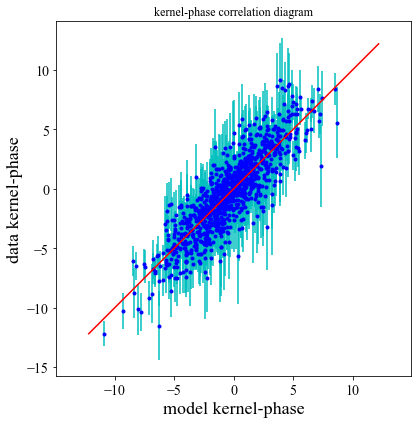

In [35]:
truth = [300,90,25]
cal = ca2_cube[0,:,:]

simulate(truth,cal)


Cube slice   1 /  50First time for m2pix = 3616.33: 
LDFT1: Computing new Fourier matrix...
Done!
Cube slice  50 /  50

First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...
Done!

binary model fitting...
[-4.01022232e-09]
sep = 76.710470, ang=93.624874, con=19.302924 => chi2 = 0.795
correlation matrix of parameters
[[ 9.89 -0.06  3.11]
 [-0.06  0.22 -0.03]
 [ 3.11 -0.03  1.1 ]]
Estimated Uncertainty
[3.14494167 0.46502677 1.04665324]
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...
Done!

binary model fitting...
[-7.67038137e-11]
sep = 81.798415, ang=93.286723, con=20.545113 => chi2 = 0.800
correlation matrix of parameters
[[ 8.13 -0.06  1.93]
 [-0.06  0.2  -0.02]
 [ 1.93 -0.02  0.58]]
Estimated Uncertainty
[2.85109884 0.45120359 0.76423971]
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...
Done!

binary model fitting...
[-2.88574327e-08]
sep = 86.841328, ang=92.990005, con=21.625795 => chi2 = 0.805
correlation matrix of parameters
[[ 6.77 -0.06  1.06]
 [-0.06  0.19 -0.02]
 [ 1.06 -0.02  0.31]]
Estimated Uncertainty
[2.60129915 0.4414419  0.55359393

/Users/benjaminpope/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:132: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Done!

binary model fitting...
[-9.55975548e-09]
sep = 183.689675, ang=90.182170, con=23.494080 => chi2 = 0.851
correlation matrix of parameters
[[ 1.37 -0.02  0.74]
 [-0.02  0.08 -0.02]
 [ 0.74 -0.02  0.83]]
Estimated Uncertainty
[1.17105494 0.28429889 0.90908957]
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...
Done!

binary model fitting...
[-1.53406863e-08]
sep = 187.784519, ang=90.183042, con=23.469195 => chi2 = 0.849
correlation matrix of parameters
[[ 1.42 -0.02  0.73]
 [-0.02  0.07 -0.02]
 [ 0.73 -0.02  0.73]]
Estimated Uncertainty
[1.19117025 0.26486349 0.85545452]
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...
Done!

binary model fitting...
[-3.71511072e-09]
sep = 191.643206, ang=90.180326, con=23.314399 => chi2 = 0.848
correlation matrix of parameters
[[ 1.44 -0.03  0.69]
 [-0.03  0.06 -0.02]
 [ 0.69 -0.02  0.63]]
Estimated Uncertainty
[1.19925954 0.24713421 0.79064071]
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matri

Done!

binary model fitting...
[-7.58438222e-09]
sep = 284.625354, ang=89.747399, con=25.260185 => chi2 = 0.870
correlation matrix of parameters
[[0.57 0.   0.05]
 [0.   0.02 0.  ]
 [0.05 0.   0.17]]
Estimated Uncertainty
[0.75765209 0.15102796 0.40674539]
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...
Done!

binary model fitting...
[-1.06298451e-08]
sep = 289.541852, ang=89.772738, con=25.421299 => chi2 = 0.875
correlation matrix of parameters
[[0.65 0.01 0.05]
 [0.01 0.02 0.  ]
 [0.05 0.   0.16]]
Estimated Uncertainty
[0.80340158 0.14708183 0.40538763]
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...
Done!

binary model fitting...
[-1.23207765e-08]
sep = 294.639152, ang=89.805165, con=25.561324 => chi2 = 0.878
correlation matrix of parameters
[[0.73 0.01 0.05]
 [0.01 0.02 0.  ]
 [0.05 0.   0.16]]
Estimated Uncertainty
[0.85366186 0.14310683 0.40226822]
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...
Done!

binary model fi

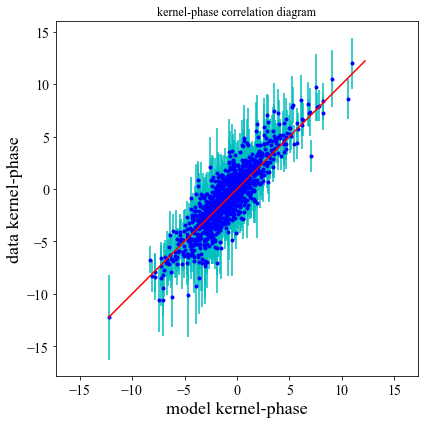

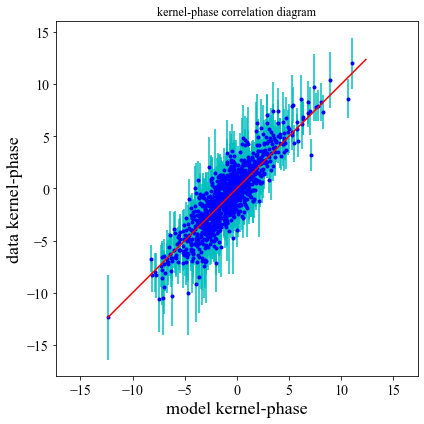

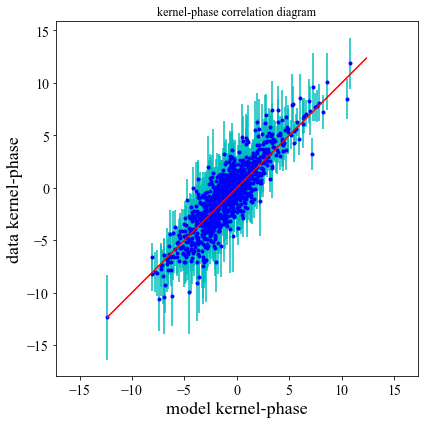

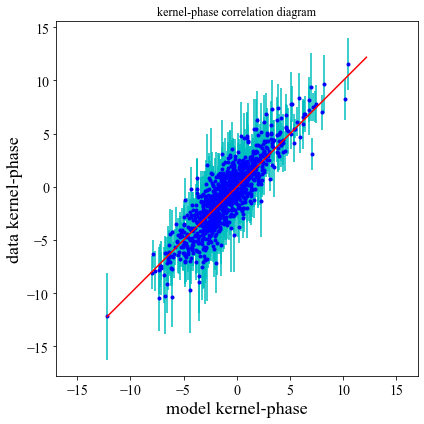

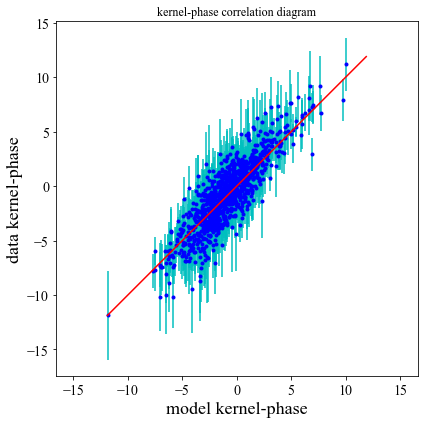

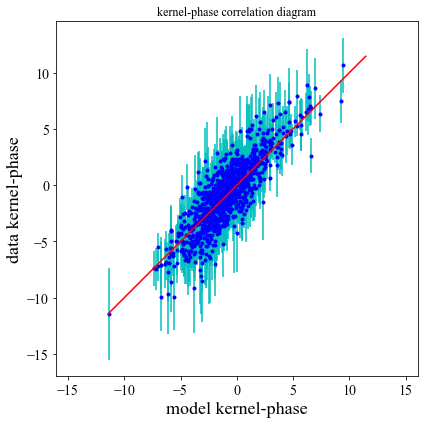

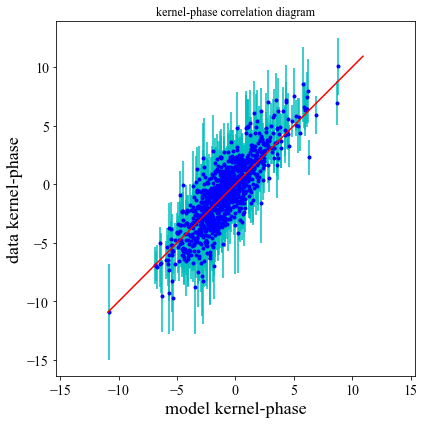

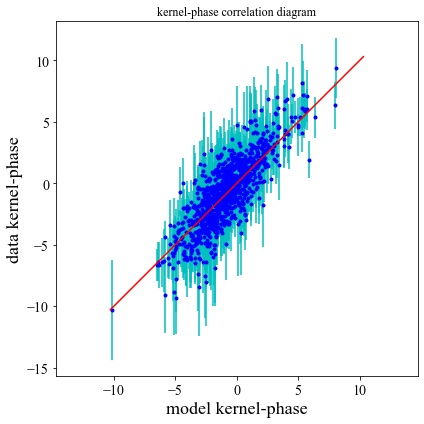

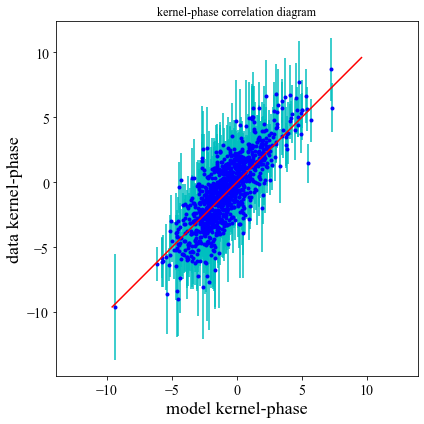

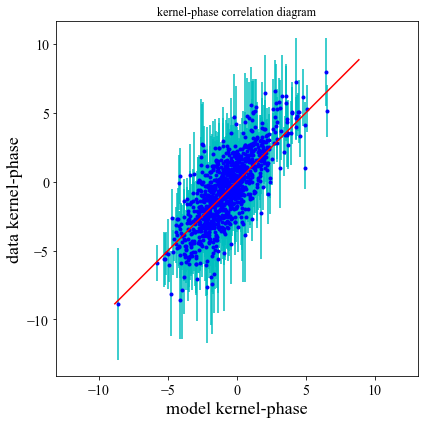

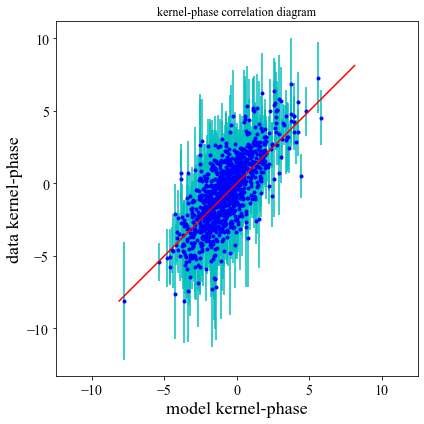

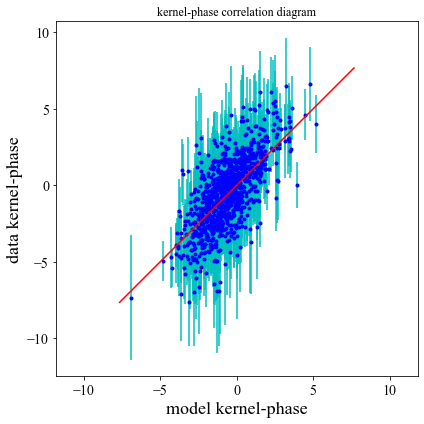

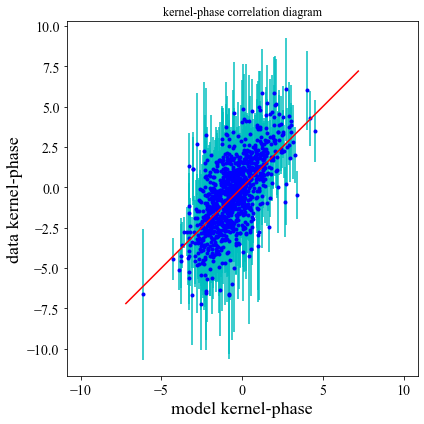

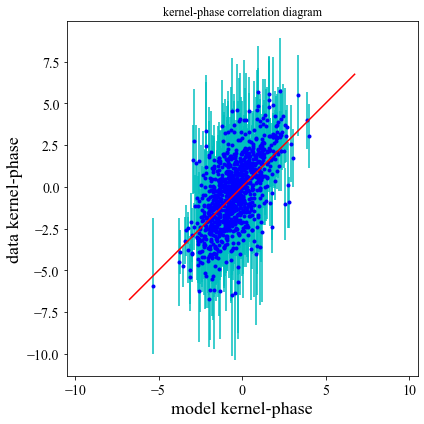

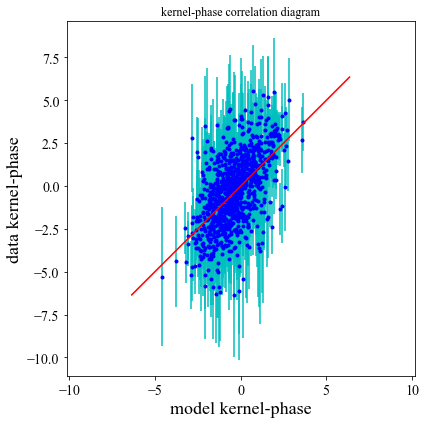

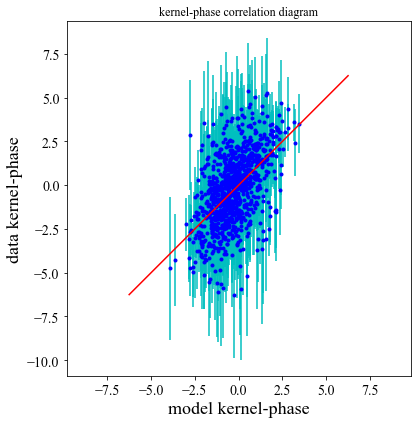

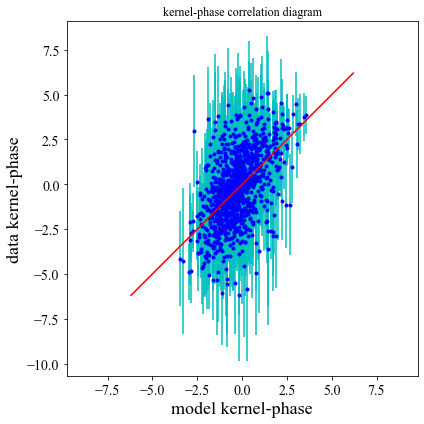

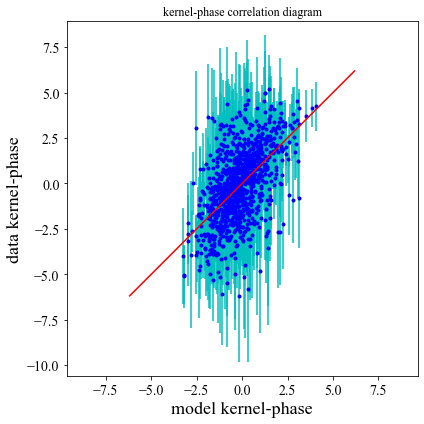

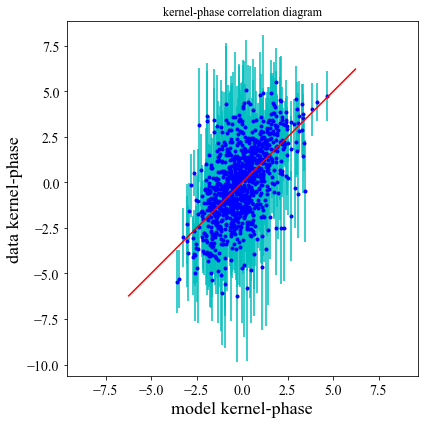

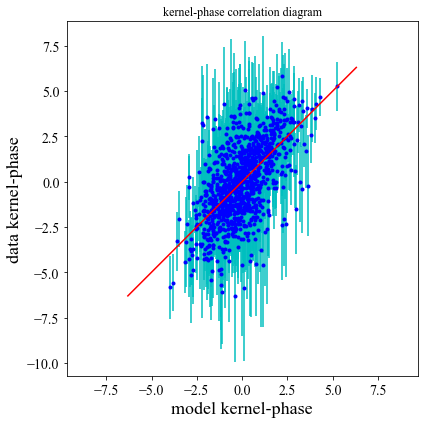

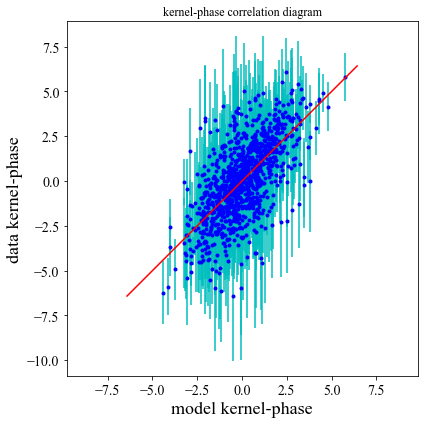

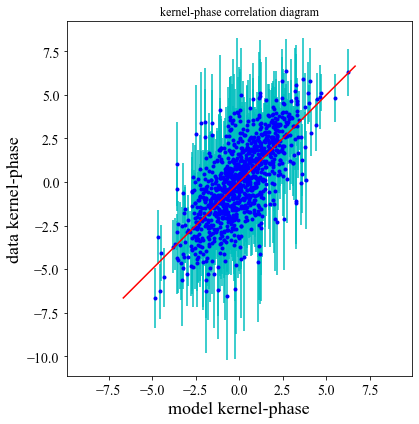

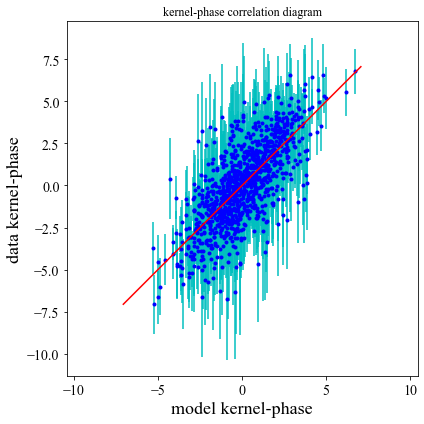

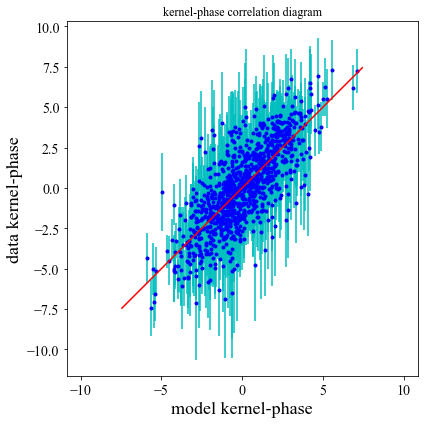

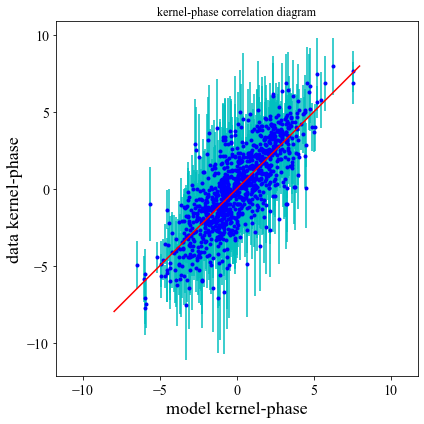

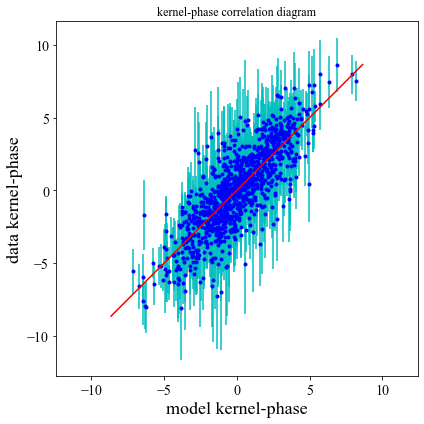

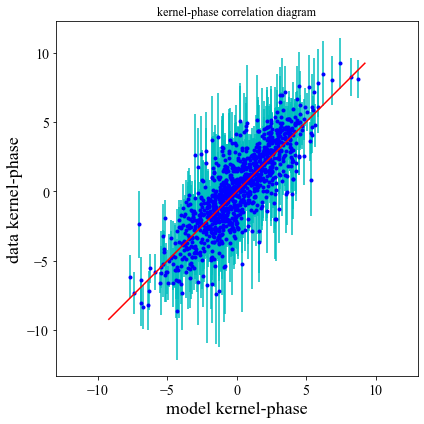

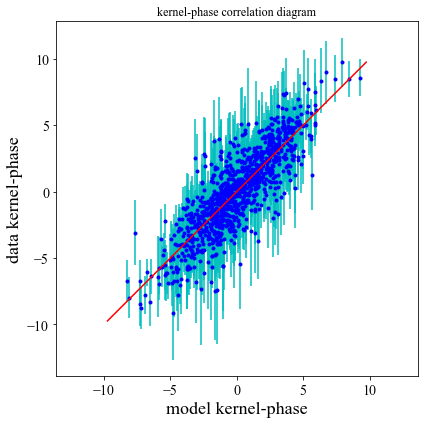

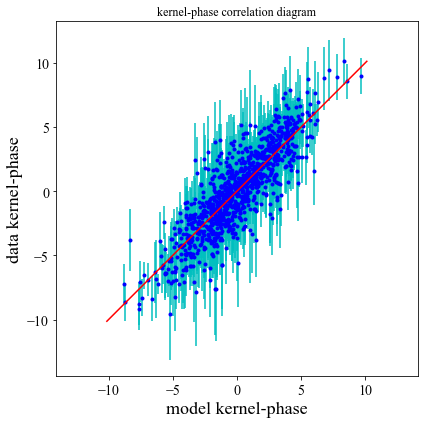

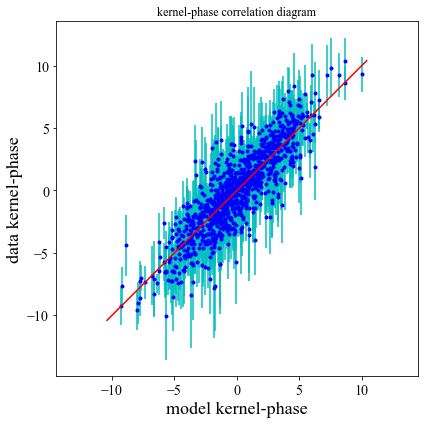

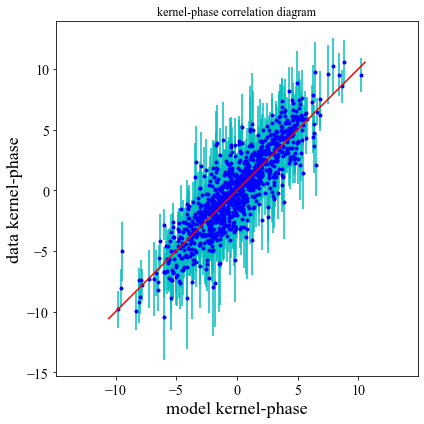

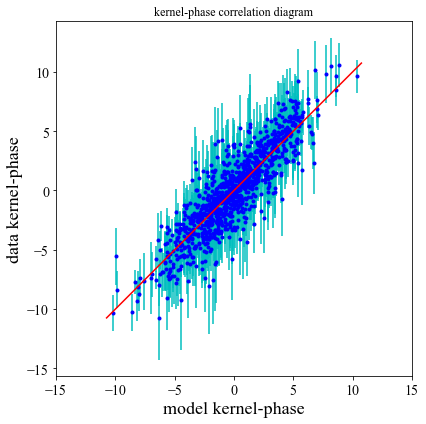

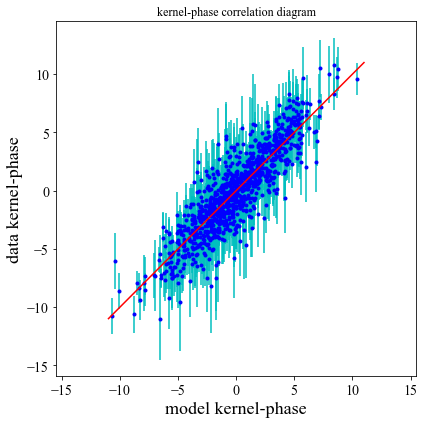

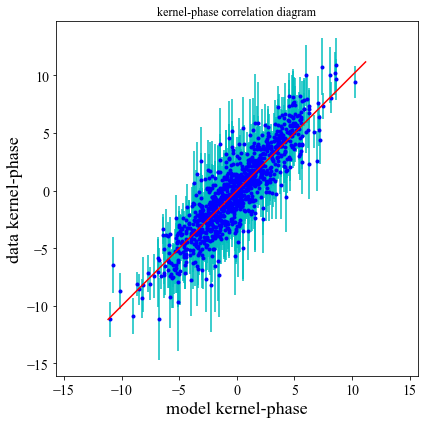

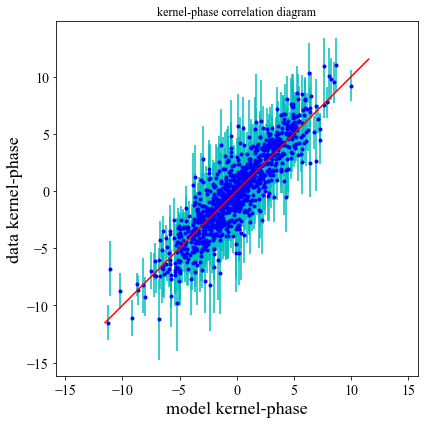

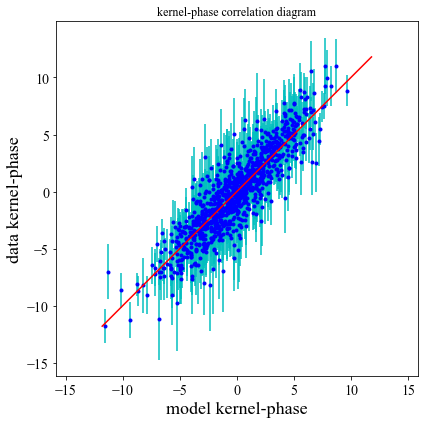

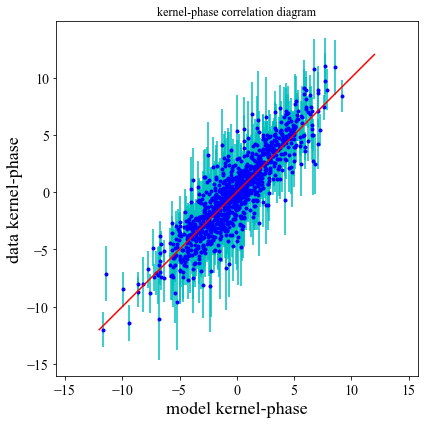

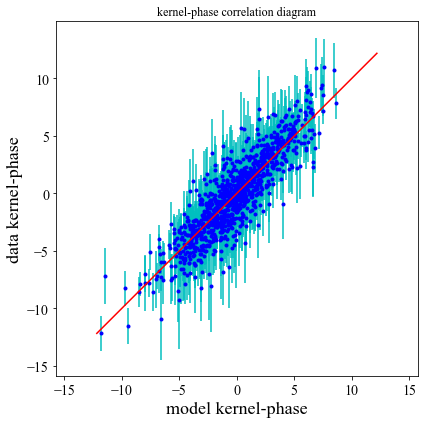

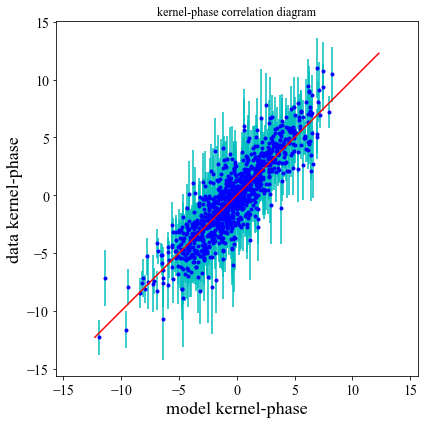

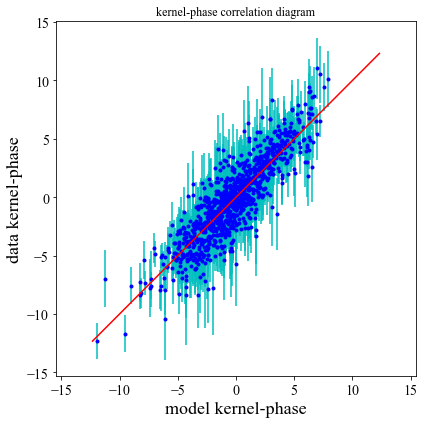

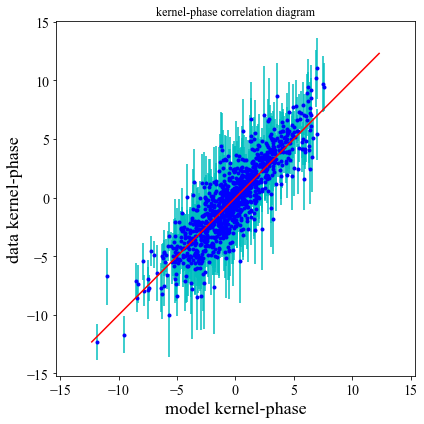

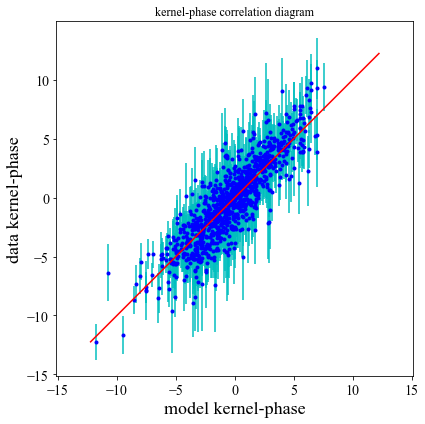

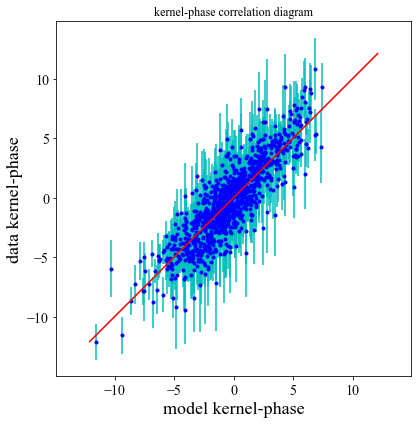

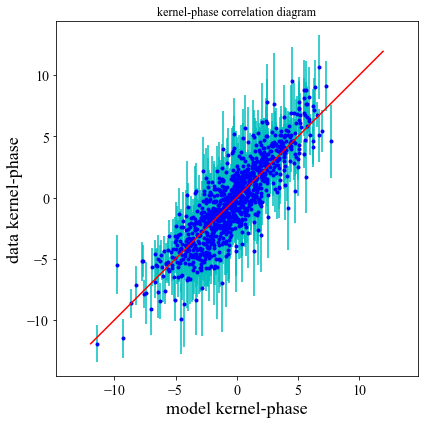

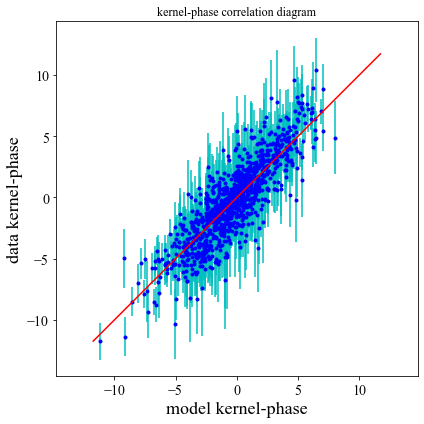

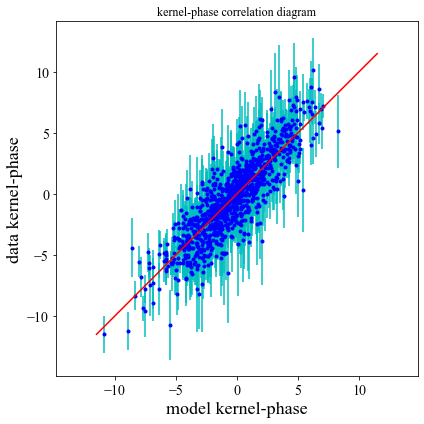

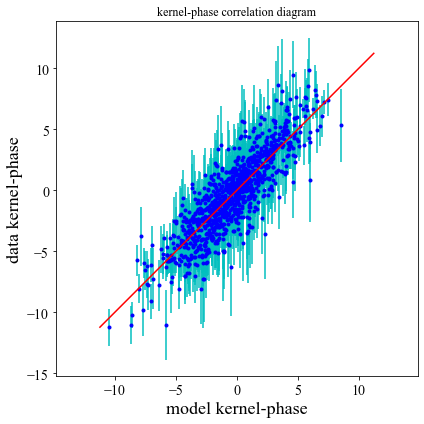

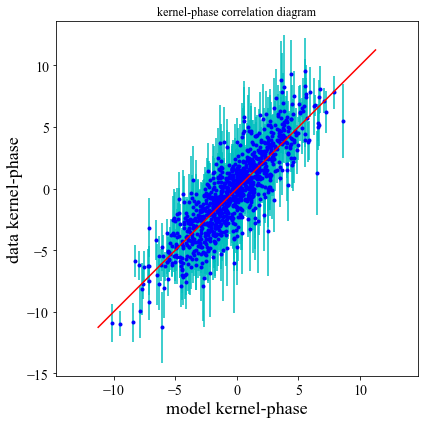

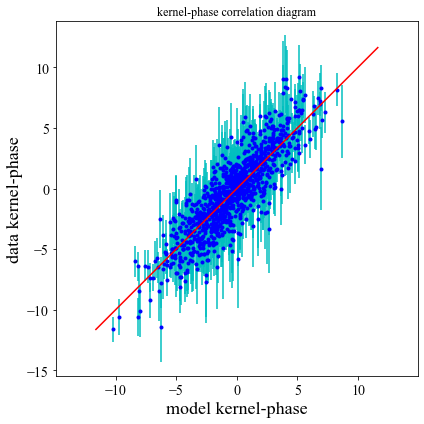

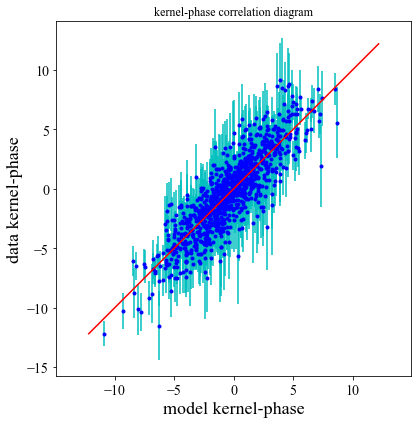

In [36]:
# %%time
seps_out, thetas_out, cons_out = [], [], []
dseps_out, dthetas_out, dcons_out = [], [], []

kpo_cal = c.copy()
kpo_cal.extract_KPD_single_cube(
        ca2_cube[50:,:,:], pscale*1000, wl, target="epsilon Herculis", recenter=True,method='LDFT1')

calib = np.median(kpo_cal.KPDT[0],axis=0)

ss, tt, cc = [], [], []
seps_in = onp.linspace(90,300,50)

for j, sep_in in enumerate(tqdm(seps_in)):
    cal = ca2_cube[0,:,:]
    truth = [sep_in,90,25]
    p1, uncertainty = simulate(truth,cal)
    ss.append(p1[0])
    tt.append(p1[1])
    cc.append(p1[2])
    
    seps_out.append(p1[0])
    thetas_out.append(p1[1])
    cons_out.append(p1[2])

    dseps_out.append(uncertainty[0])
    dthetas_out.append(uncertainty[1])
    dcons_out.append(uncertainty[2])

#     except:
#         print('Failed on',j)
#         seps_out.append(np.nan)
#         thetas_out.append(np.nan)
#         cons_out.append(np.nan)

#         dseps_out.append(np.nan)
#         dthetas_out.append(np.nan)
#         dcons_out.append(np.nan)

seps_out, thetas_out, cons_out = np.array(seps_out), np.array(thetas_out), np.array(cons_out)
dseps_out, dthetas_out, dcons_out = np.array(dseps_out), np.array(dthetas_out), np.array(dcons_out)


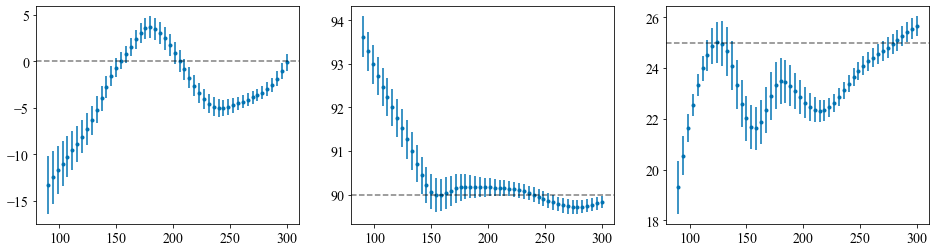

In [37]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(16.0,4.0))
inds = np.arange(len(seps_in))

ax1.plot(seps_in,seps_out-seps_in,'.')
# ax1.plot(seps_in,seps_in,'--')

ax1.axhline(0,color='k',linestyle='--',alpha=0.5)
ax1.errorbar(seps_in,seps_out-seps_in,yerr=dseps_out,ls='none',color=colours[0])

# ax1.plot(seps_in,seps_in,'--k',alpha=0.5)

ax2.plot(seps_in,thetas_out,'.')
ax2.axhline(truth[1],color='k',linestyle='--',alpha=0.5)
ax2.errorbar(seps_in,thetas_out,yerr=dthetas_out,ls='none',color=colours[0])

ax3.plot(seps_in,cons_out,'.')
ax3.errorbar(seps_in,cons_out,yerr=dcons_out,ls='none',color=colours[0])

ax3.axhline(truth[2],color='k',linestyle='--',alpha=0.5)

In [38]:
autodiff_recovered = onp.loadtxt('autodiff_recovery.txt')

In [39]:
seps_out_a, thetas_out_a, cons_out_a,dseps_out_a, dthetas_out_a, dcons_out_a = autodiff_recovered.T

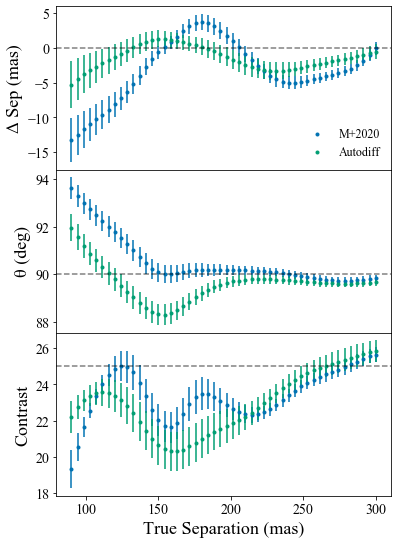

In [40]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(6.0,9.0),sharex=True)
inds = np.arange(len(seps_in))

ax1.plot(seps_in,seps_out-seps_in,'.',label='M+2020')
ax1.plot(seps_in,seps_out_a-seps_in,'.',color=colours[1],label='Autodiff')
# ax1.plot(seps_in,seps_in,'--')
ax1.legend(loc=4,frameon=False,fontsize=12)

ax1.axhline(0,color='k',linestyle='--',alpha=0.5)
ax1.errorbar(seps_in,seps_out-seps_in,yerr=dseps_out,ls='none',color=colours[0])
ax1.errorbar(seps_in,seps_out_a-seps_in,yerr=dseps_out_a,ls='none',color=colours[1])
ax1.set_xticks([])
ax1.set_ylabel(r'Δ Sep (mas)')
# ax1.plot(seps_in,seps_in,'--k',alpha=0.5)

ax2.plot(seps_in,thetas_out,'.')
ax2.plot(seps_in,thetas_out_a,'.',color=colours[1])

ax2.axhline(truth[1],color='k',linestyle='--',alpha=0.5)
ax2.errorbar(seps_in,thetas_out,yerr=dthetas_out,ls='none',color=colours[0])
ax2.errorbar(seps_in,thetas_out_a,yerr=dthetas_out_a,ls='none',color=colours[1])

ax2.set_xticks([])
ax2.set_ylabel('θ (deg)')

ax3.plot(seps_in,cons_out,'.')
ax3.plot(seps_in,cons_out_a,'.',color=colours[1])

ax3.errorbar(seps_in,cons_out,yerr=dcons_out,ls='none',color=colours[0])
ax3.errorbar(seps_in,cons_out_a,yerr=dcons_out_a,ls='none',color=colours[1])

ax3.axhline(truth[2],color='k',linestyle='--',alpha=0.5)
ax3.set_xticks(np.arange(100,350,50))
ax3.set_ylabel('Contrast')
ax3.set_xlabel('True Separation (mas)')
plt.subplots_adjust(wspace=0, hspace=0)

plt.savefig('injection_recovery_pharo.png',bbox_inches='tight')
plt.savefig('../paper/injection_recovery_pharo.pdf',bbox_inches='tight')